(Python ETL)
Função: Camada de processamento e preparação de dados

O que faz:

 Gera dados sintéticos de entregas e clientes (simulando um banco de dados real)

 Processa e limpa os dados (ETL)

 Cria features para machine learning

 Gera KPIs para dashboards

 Organiza os dados em camadas (raw -> processed -> curated)

Saídas:

cleaned_deliveries.parquet -> Dados limpos das entregas

enriched_customers.parquet -> Clientes com métricas

kpi_deliveries.parquet -> Métricas consolidadas para BI

ml_features.parquet -> Features para modelos de ML

 Ambiente configurado!
 Dados sample gerados!
 Entregas: 100 registros
 Clientes: 20 registros

 Preview dos dados:
Entregas:
  delivery_id customer_id  order_date estimated_delivery actual_delivery  \
0      DEL001     CUST009  2024-01-09         2024-01-14      2024-01-15   
1      DEL002     CUST001  2024-03-06         2024-03-11      2024-03-11   
2      DEL003     CUST008  2024-03-10         2024-03-15      2024-03-15   

  origin_city destination_city  weight_kg           carrier    status  \
0     Vitória          Goiânia        2.5  Transportadora A  Entregue   
1   Fortaleza           Recife        7.3  Transportadora A  Entregue   
2       Belém           Maceió        6.2  Transportadora C  Entregue   

   delay_hours  
0           24  
1            0  
2            0  

Clientes:
  customer_id   customer_name customer_segment registration_date state  \
0     CUST001  Empresa A Ltda           Medium        2023-04-08    PR   
1     CUST002  Empresa B Ltda           Medium   

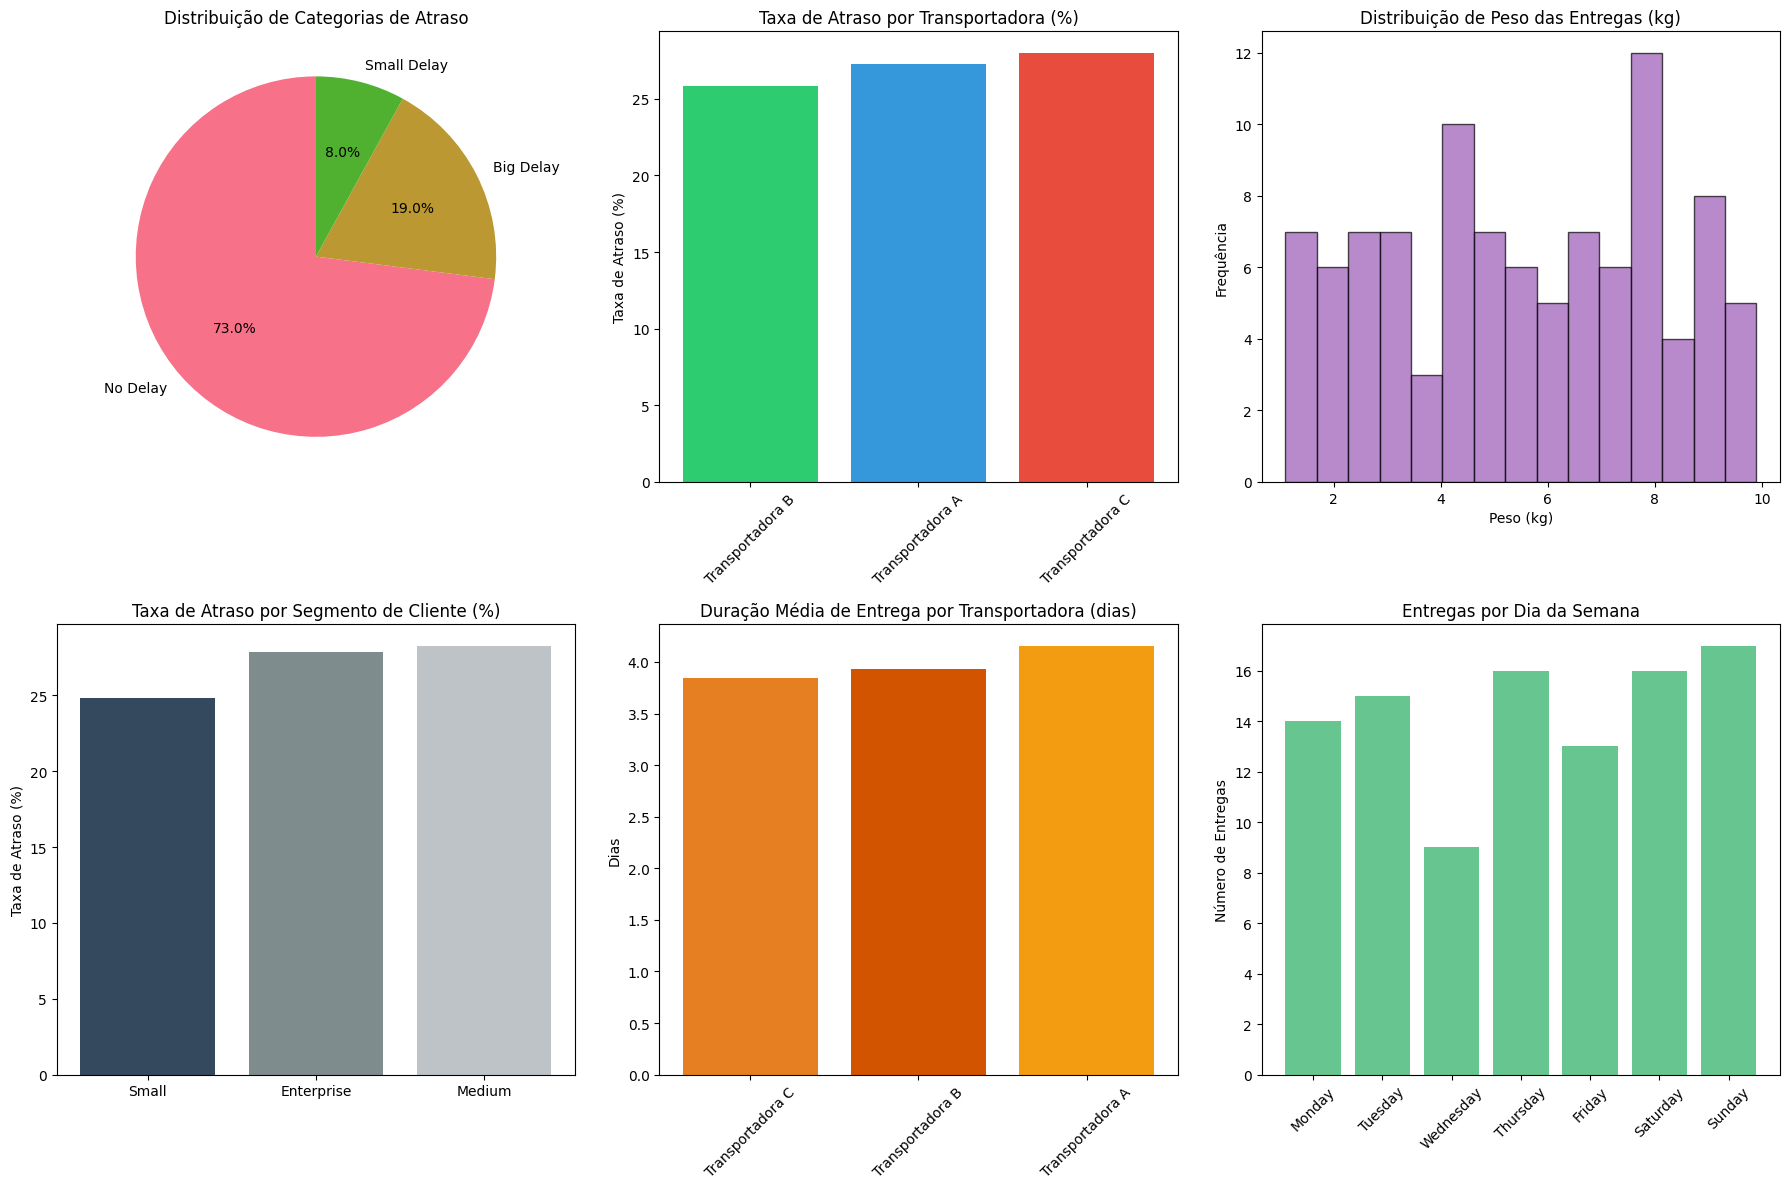


 MÉTRICAS PRINCIPAIS:
• Total de entregas: 100
• Taxa geral de atraso: 27.0%
• Número de clientes: 20
• Transportadora com menor atraso: Transportadora B (25.8%)
• Transportadora com maior atraso: Transportadora C (28.0%)
• Segmento com menor taxa de atraso: Small (24.9%)
• Duração média de entrega: 4.0 dias

  TOP 5 ROTAS MAIS COMUNS:
   Goiânia → Campinas: 4 entregas
   Cuiabá → Vitória: 2 entregas
   Rio de Janeiro → Belo Horizonte: 2 entregas
   Vitória → Recife: 2 entregas
   Vitória → Goiânia: 2 entregas
 Estrutura do projeto salva no Colab!
 Arquivos disponíveis:
./data/curated/kpi_deliveries.parquet
./data/curated/ml_features.parquet
./data/processed/cleaned_deliveries.parquet
./data/processed/enriched_customers.parquet
./data/raw/customers_sample.csv
./data/raw/deliveries_sample.csv
./sample_data/california_housing_test.csv
./sample_data/california_housing_train.csv
./sample_data/mnist_test.csv
./sample_data/mnist_train_small.csv
./scripts/analysis/exploratory_analysis.py
./s

In [1]:
# -*- coding: utf-8 -*-
"""ETL.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1uDkUVVWFmLwkSf627E_Kyf3elJsGgi8P

Configurar o ambiente
"""

#  CONFIGURAÇÃO INICIAL DO COLAB
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
import logging

# Configurar visualizações
plt.style.use('default')
sns.set_palette("husl")

# Criar estrutura de pastas no Colab
!mkdir -p data/raw data/processed data/curated
!mkdir -p scripts/etl scripts/analysis scripts/ml-models

print(" Ambiente configurado!")

"""Gerar dados sample"""

#  GERAR DADOS SAMPLE
def generate_sample_data():
    """Gera dados de exemplo para o projeto"""

    # Cidades brasileiras
    cities = ['São Paulo', 'Rio de Janeiro', 'Belo Horizonte', 'Porto Alegre', 'Recife',
              'Salvador', 'Fortaleza', 'Curitiba', 'Goiânia', 'Belém', 'Maceió', 'Natal',
              'Vitória', 'Florianópolis', 'Manaus', 'Cuiabá', 'Campinas']

    # Transportadoras
    carriers = ['Transportadora A', 'Transportadora B', 'Transportadora C']

    # Gerar entregas
    deliveries = []
    for i in range(1, 101):
        delivery_id = f"DEL{str(i).zfill(3)}"
        customer_id = f"CUST{str(random.randint(1, 20)).zfill(3)}"

        order_date = datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90))
        estimated_days = random.randint(2, 5)
        estimated_delivery = order_date + timedelta(days=estimated_days)

        # 70% no prazo, 30% com atraso
        if random.random() < 0.7:
            actual_delivery = estimated_delivery
            delay_hours = 0
        else:
            delay_days = random.randint(1, 3)
            actual_delivery = estimated_delivery + timedelta(days=delay_days)
            delay_hours = delay_days * 24

        origin = random.choice(cities)
        destination = random.choice([c for c in cities if c != origin])
        weight = round(random.uniform(1.0, 10.0), 1)
        carrier = random.choice(carriers)

        deliveries.append({
            'delivery_id': delivery_id,
            'customer_id': customer_id,
            'order_date': order_date.strftime('%Y-%m-%d'),
            'estimated_delivery': estimated_delivery.strftime('%Y-%m-%d'),
            'actual_delivery': actual_delivery.strftime('%Y-%m-%d'),
            'origin_city': origin,
            'destination_city': destination,
            'weight_kg': weight,
            'carrier': carrier,
            'status': 'Entregue',
            'delay_hours': delay_hours
        })

    # Gerar clientes
    customers = []
    for i in range(1, 21):
        customer_id = f"CUST{str(i).zfill(3)}"
        customer_name = f"Empresa {chr(64 + i)} Ltda"
        segment = random.choice(['Enterprise', 'Medium', 'Small'])

        reg_date = datetime(2023, 1, 1) + timedelta(days=random.randint(0, 365))
        state = random.choice(['SP', 'MG', 'RS', 'CE', 'BA', 'PR', 'GO'])

        if segment == 'Enterprise':
            monthly_spend = round(random.uniform(10000, 20000), 2)
            total_orders = random.randint(40, 60)
            rating = round(random.uniform(4.0, 5.0), 1)
        elif segment == 'Medium':
            monthly_spend = round(random.uniform(5000, 10000), 2)
            total_orders = random.randint(20, 40)
            rating = round(random.uniform(3.5, 4.5), 1)
        else:
            monthly_spend = round(random.uniform(2000, 5000), 2)
            total_orders = random.randint(10, 20)
            rating = round(random.uniform(3.0, 4.0), 1)

        customers.append({
            'customer_id': customer_id,
            'customer_name': customer_name,
            'customer_segment': segment,
            'registration_date': reg_date.strftime('%Y-%m-%d'),
            'state': state,
            'monthly_spend_avg': monthly_spend,
            'total_orders': total_orders,
            'avg_delivery_rating': rating
        })

    # Criar DataFrames
    deliveries_df = pd.DataFrame(deliveries)
    customers_df = pd.DataFrame(customers)

    # Salvar como CSV
    deliveries_df.to_csv('data/raw/deliveries_sample.csv', index=False)
    customers_df.to_csv('data/raw/customers_sample.csv', index=False)

    print(" Dados sample gerados!")
    print(f" Entregas: {len(deliveries_df)} registros")
    print(f" Clientes: {len(customers_df)} registros")

    return deliveries_df, customers_df

# Executar geração de dados
deliveries_raw, customers_raw = generate_sample_data()

# Mostrar preview
print("\n Preview dos dados:")
print("Entregas:")
print(deliveries_raw.head(3))
print("\nClientes:")
print(customers_raw.head(3))

"""DataLoader Class"""

import pandas as pd
import os
from typing import Dict
import logging

logger = logging.getLogger(__name__)

class DataLoader:
    def __init__(self, base_path: str = "data"):
        self.base_path = base_path
        self.processed_path = os.path.join(base_path, "processed")
        self.curated_path = os.path.join(base_path, "curated")

        # Criar diretórios se não existirem
        os.makedirs(self.processed_path, exist_ok=True)
        os.makedirs(self.curated_path, exist_ok=True)

    def save_processed_data(self, deliveries_df: pd.DataFrame, customers_df: pd.DataFrame):
        """Salva dados processados"""
        try:
            # Salvar dados processados
            deliveries_path = os.path.join(self.processed_path, "cleaned_deliveries.parquet")
            customers_path = os.path.join(self.processed_path, "enriched_customers.parquet")

            deliveries_df.to_parquet(deliveries_path, index=False)
            customers_df.to_parquet(customers_path, index=False)

            print(f" Dados processados salvos em {self.processed_path}")

        except Exception as e:
            print(f" Erro ao salvar dados processados: {e}")
            raise

    def save_curated_data(self, kpi_df: pd.DataFrame, ml_features_df: pd.DataFrame):
        """Salva dados curados para BI e ML"""
        try:
            # Salvar dados curados
            kpi_path = os.path.join(self.curated_path, "kpi_deliveries.parquet")
            ml_path = os.path.join(self.curated_path, "ml_features.parquet")

            kpi_df.to_parquet(kpi_path, index=False)
            ml_features_df.to_parquet(ml_path, index=False)

            print(f" Dados curados salvos em {self.curated_path}")

        except Exception as e:
            print(f" Erro ao salvar dados curados: {e}")
            raise

    def load_data_for_analysis(self, data_type: str = "curated") -> Dict[str, pd.DataFrame]:
        """Carrega dados para análise"""
        data_path = self.curated_path if data_type == "curated" else self.processed_path

        try:
            data_files = {}
            for file in os.listdir(data_path):
                if file.endswith('.parquet'):
                    name = file.replace('.parquet', '')
                    file_path = os.path.join(data_path, file)
                    data_files[name] = pd.read_parquet(file_path)

            print(f" Carregados {len(data_files)} datasets para análise")
            return data_files

        except Exception as e:
            print(f" Erro ao carregar dados para análise: {e}")
            raise

"""Função para criar datasets curados"""

#  GERAR DADOS CURADOS PARA BI E ML
def create_curated_datasets(deliveries_df, customers_df):
    """Cria datasets curados para análise de BI e modelos de ML"""
    print(" Criando datasets curados...")

    # ========== DATASET DE KPIs ==========
    kpi_data = deliveries_df.groupby(['customer_id', 'carrier', 'origin_city', 'destination_city']).agg({
        'delivery_id': 'count',
        'is_delayed': 'mean',
        'delay_hours': ['mean', 'max'],
        'delivery_duration': 'mean',
        'weight_kg': 'mean'
    }).round(3)

    # Ajustar nomes das colunas
    kpi_data.columns = ['total_deliveries', 'delay_rate', 'avg_delay_hours',
                       'max_delay_hours', 'avg_delivery_duration', 'avg_weight_kg']
    kpi_data = kpi_data.reset_index()

    # Enriquecer com dados do cliente
    kpi_data = kpi_data.merge(
        customers_df[['customer_id', 'customer_segment', 'state', 'monthly_spend_avg']],
        on='customer_id',
        how='left'
    )

    # ========== DATASET PARA ML ==========
    ml_features = deliveries_df.copy()

    # Adicionar features temporais
    ml_features['order_day_of_week_num'] = ml_features['order_date'].dt.dayofweek
    ml_features['order_month_num'] = ml_features['order_date'].dt.month
    ml_features['order_week'] = ml_features['order_date'].dt.isocalendar().week

    # Features de rota
    ml_features['route'] = ml_features['origin_city'] + '_' + ml_features['destination_city']

    # Engenharia de features para ML
    ml_features = ml_features[[
        'delivery_id', 'customer_id', 'carrier', 'origin_city', 'destination_city',
        'route', 'weight_kg', 'order_day_of_week_num', 'order_month_num', 'order_week',
        'estimated_duration', 'delivery_duration', 'delay_hours', 'is_delayed', 'delay_category'
    ]]

    print(f" Datasets curados criados:")
    print(f"   - KPI Data: {len(kpi_data)} registros")
    print(f"   - ML Features: {len(ml_features)} registros")

    return kpi_data, ml_features

"""Pipeline ETL Completo"""

#  PIPELINE ETL COMPLETO
def run_etl_pipeline():
    print(" Iniciando Pipeline ETL...")

    # Ler dados brutos
    deliveries = pd.read_csv('data/raw/deliveries_sample.csv', parse_dates=['order_date', 'estimated_delivery', 'actual_delivery'])
    customers = pd.read_csv('data/raw/customers_sample.csv', parse_dates=['registration_date'])

    # ========== TRANSFORMAÇÃO DE ENTREGAS ==========
    print(" Processando entregas...")

    # Limpeza básica
    deliveries_clean = deliveries.drop_duplicates()

    # Feature engineering
    deliveries_clean['is_delayed'] = (deliveries_clean['delay_hours'] > 0).astype(int)
    deliveries_clean['delivery_duration'] = (deliveries_clean['actual_delivery'] - deliveries_clean['order_date']).dt.days
    deliveries_clean['estimated_duration'] = (deliveries_clean['estimated_delivery'] - deliveries_clean['order_date']).dt.days

    # Categorizar atrasos
    conditions = [
        deliveries_clean['delay_hours'] <= 0,
        (deliveries_clean['delay_hours'] > 0) & (deliveries_clean['delay_hours'] <= 24),
        deliveries_clean['delay_hours'] > 24
    ]
    choices = ['No Delay', 'Small Delay', 'Big Delay']
    deliveries_clean['delay_category'] = np.select(conditions, choices, default='Unknown')

    # Features temporais
    deliveries_clean['order_day_of_week'] = deliveries_clean['order_date'].dt.day_name()
    deliveries_clean['order_month'] = deliveries_clean['order_date'].dt.month_name()

    # ========== ENRIQUECIMENTO DE CLIENTES ==========
    print("👥 Enriquecendo dados de clientes...")

    # Métricas por cliente
    customer_metrics = deliveries_clean.groupby('customer_id').agg({
        'delivery_id': 'count',
        'delay_hours': ['mean', 'max'],
        'is_delayed': 'sum',
        'weight_kg': 'mean'
    }).round(2)

    # Ajustar nomes das colunas
    customer_metrics.columns = ['total_deliveries', 'avg_delay_hours', 'max_delay_hours', 'delayed_deliveries', 'avg_weight_kg']

    # Calcular taxa de atraso
    customer_metrics['delay_rate'] = (customer_metrics['delayed_deliveries'] / customer_metrics['total_deliveries']).round(3)

    # Juntar com dados originais
    customers_enriched = customers.merge(customer_metrics, on='customer_id', how='left')

    # Preencher valores nulos
    customers_enriched = customers_enriched.fillna({
        'total_deliveries': 0,
        'delayed_deliveries': 0,
        'delay_rate': 0,
        'avg_delay_hours': 0,
        'max_delay_hours': 0,
        'avg_weight_kg': 0
    })

    # ========== DADOS CURADOS ==========
    print(" Gerando dados curados...")
    kpi_data, ml_features = create_curated_datasets(deliveries_clean, customers_enriched)

    # ========== SALVAR TODOS OS DADOS ==========
    print(" Salvando todos os dados...")

    # Usar o DataLoader para salvar
    loader = DataLoader()
    loader.save_processed_data(deliveries_clean, customers_enriched)
    loader.save_curated_data(kpi_data, ml_features)

    print(" Pipeline ETL completo concluído!")

    # Estatísticas finais
    print(f"\n ESTATÍSTICAS FINAIS:")
    print(f"    Entregas processadas: {len(deliveries_clean)}")
    print(f"    Clientes enriquecidos: {len(customers_enriched)}")
    print(f"    KPIs calculados: {len(kpi_data)}")
    print(f"    Features para ML: {len(ml_features)}")
    print(f"    Taxa de atraso geral: {(deliveries_clean['is_delayed'].mean() * 100):.1f}%")

    return deliveries_clean, customers_enriched, kpi_data, ml_features

# Executar ETL completo
cleaned_deliveries, enriched_customers, kpi_data, ml_features = run_etl_pipeline()

"""Verificar todos os arquivos gerados"""

#  VERIFICAR TODOS OS ARQUIVOS GERADOS
print(" ESTRUTURA COMPLETA DE ARQUIVOS GERADOS:")
!find data -type f -name "*.csv" -o -name "*.parquet" | sort

print("\n RESUMO DOS DATASETS:")
datasets = {
    'cleaned_deliveries': cleaned_deliveries,
    'enriched_customers': enriched_customers,
    'kpi_data': kpi_data,
    'ml_features': ml_features
}

for name, df in datasets.items():
    print(f"   {name}: {df.shape}")

print("\n Conteúdo dos arquivos processados:")

# Ler e mostrar dados processados
df_deliveries = pd.read_parquet('data/processed/cleaned_deliveries.parquet')
df_customers = pd.read_parquet('data/processed/enriched_customers.parquet')

print(f"\n cleaned_deliveries.parquet")
print(f"   Dimensões: {df_deliveries.shape}")
print(f"   Colunas: {list(df_deliveries.columns)}")
print(f"   Amostra de dados:")
print(df_deliveries[['delivery_id', 'carrier', 'is_delayed', 'delay_category', 'order_day_of_week']].head(3))

print(f"\n enriched_customers.parquet")
print(f"   Dimensões: {df_customers.shape}")
print(f"   Colunas: {list(df_customers.columns)}")
print(f"   Amostra de dados:")
print(df_customers[['customer_id', 'customer_segment', 'total_deliveries', 'delay_rate', 'avg_delay_hours']].head(3))

# Mostrar dados curados
print(f"\n kpi_deliveries.parquet")
print(f"   Dimensões: {kpi_data.shape}")
print(f"   Colunas: {list(kpi_data.columns)}")
print(f"   Amostra de dados:")
print(kpi_data[['customer_id', 'carrier', 'total_deliveries', 'delay_rate', 'avg_delivery_duration']].head(3))

print(f"\n ml_features.parquet")
print(f"   Dimensões: {ml_features.shape}")
print(f"   Colunas: {list(ml_features.columns)}")
print(f"   Amostra de dados:")
print(ml_features[['delivery_id', 'route', 'order_day_of_week_num', 'is_delayed']].head(3))

"""Testar DataLoader"""

#  TESTAR DATALOADER
print(" Testando DataLoader...")

loader = DataLoader()

# Carregar dados para análise
data_files = loader.load_data_for_analysis("curated")
print(f" Datasets carregados: {list(data_files.keys())}")

# Carregar dados processados
processed_files = loader.load_data_for_analysis("processed")
print(f" Datasets processados: {list(processed_files.keys())}")

"""Análise Exploratória (EDA) Completa"""

#  ANÁLISE EXPLORATÓRIA DOS DADOS
print(" ANÁLISE EXPLORATÓRIA DOS DADOS PROCESSADOS")

# Configurar plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribuição de atrasos
delay_counts = cleaned_deliveries['delay_category'].value_counts()
axes[0,0].pie(delay_counts.values, labels=delay_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribuição de Categorias de Atraso')

# 2. Performance por transportadora
carrier_performance = cleaned_deliveries.groupby('carrier')['is_delayed'].mean().sort_values()
axes[0,1].bar(carrier_performance.index, carrier_performance.values * 100, color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0,1].set_title('Taxa de Atraso por Transportadora (%)')
axes[0,1].set_ylabel('Taxa de Atraso (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Distribuição de pesos
axes[0,2].hist(cleaned_deliveries['weight_kg'], bins=15, alpha=0.7, color='#9b59b6', edgecolor='black')
axes[0,2].set_title('Distribuição de Peso das Entregas (kg)')
axes[0,2].set_xlabel('Peso (kg)')
axes[0,2].set_ylabel('Frequência')

# 4. Delay rate por segmento de cliente
segment_delay = enriched_customers.groupby('customer_segment')['delay_rate'].mean().sort_values()
axes[1,0].bar(segment_delay.index, segment_delay.values * 100, color=['#34495e', '#7f8c8d', '#bdc3c7'])
axes[1,0].set_title('Taxa de Atraso por Segmento de Cliente (%)')
axes[1,0].set_ylabel('Taxa de Atraso (%)')

# 5. Duração média por transportadora
duration_by_carrier = cleaned_deliveries.groupby('carrier')['delivery_duration'].mean().sort_values()
axes[1,1].bar(duration_by_carrier.index, duration_by_carrier.values, color=['#e67e22', '#d35400', '#f39c12'])
axes[1,1].set_title('Duração Média de Entrega por Transportadora (dias)')
axes[1,1].set_ylabel('Dias')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Distribuição de entregas por dia da semana
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = cleaned_deliveries['order_day_of_week'].value_counts().reindex(day_order)
axes[1,2].bar(day_counts.index, day_counts.values, color='#27ae60', alpha=0.7)
axes[1,2].set_title('Entregas por Dia da Semana')
axes[1,2].set_ylabel('Número de Entregas')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Métricas principais
print("\n MÉTRICAS PRINCIPAIS:")
print(f"• Total de entregas: {len(cleaned_deliveries)}")
print(f"• Taxa geral de atraso: {(cleaned_deliveries['is_delayed'].mean() * 100):.1f}%")
print(f"• Número de clientes: {len(enriched_customers)}")
print(f"• Transportadora com menor atraso: {carrier_performance.index[0]} ({(carrier_performance.iloc[0] * 100):.1f}%)")
print(f"• Transportadora com maior atraso: {carrier_performance.index[-1]} ({(carrier_performance.iloc[-1] * 100):.1f}%)")
print(f"• Segmento com menor taxa de atraso: {segment_delay.index[0]} ({(segment_delay.iloc[0] * 100):.1f}%)")
print(f"• Duração média de entrega: {cleaned_deliveries['delivery_duration'].mean():.1f} dias")

# Análise das rotas mais comuns
print(f"\n  TOP 5 ROTAS MAIS COMUNS:")
top_routes = kpi_data.groupby(['origin_city', 'destination_city'])['total_deliveries'].sum().sort_values(ascending=False).head(5)
for (origin, dest), count in top_routes.items():
    print(f"   {origin} → {dest}: {count} entregas")

"""Salvar estrutura completa do projeto"""

#  SALVAR ESTRUTURA COMPLETA NO COLAB
def save_project_structure():
    """Salva todos os arquivos do projeto no Colab"""

    # Salvar script ETL completo
    etl_script = '''
# scripts/etl/etl_pipeline.py
import pandas as pd
import numpy as np
import os
from datetime import datetime
import logging

class DataLoader:
    # [Implementação completa da classe DataLoader]
    pass

def create_curated_datasets(deliveries_df, customers_df):
    # [Implementação completa da função]
    pass

def run_etl_pipeline():
    # [Implementação completa do pipeline ETL]
    pass

if __name__ == "__main__":
    cleaned_deliveries, enriched_customers, kpi_data, ml_features = run_etl_pipeline()
'''

    with open('scripts/etl/etl_pipeline.py', 'w') as f:
        f.write(etl_script)

    # Salvar script de análise
    analysis_script = '''
# scripts/analysis/exploratory_analysis.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_data():
    """Carrega dados para análise"""
    loader = DataLoader()
    return loader.load_data_for_analysis("curated")

def create_dashboards():
    """Cria dashboards de análise"""
    # [Implementação dos dashboards]
    pass
'''

    with open('scripts/analysis/exploratory_analysis.py', 'w') as f:
        f.write(analysis_script)

    print(" Estrutura do projeto salva no Colab!")
    print(" Arquivos disponíveis:")
    !find . -type f -name "*.py" -o -name "*.csv" -o -name "*.parquet" | sort

save_project_structure()

print("\n PIPELINE ETL COMPLETO EXECUTADO COM SUCESSO!")
print(" Todos os dados foram gerados e processados:")
print("    Dados sample (raw)")
print("    Dados processados (processed)")
print("    Dados curados (curated)")
print("    Análises e visualizações")
print("    Scripts organizados")